# Previsão de valores do aluguel de imóveis no município de São Paulo


In [46]:
import pandas as pd
import time
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, DBSCAN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from matplotlib.ticker import FuncFormatter

In [47]:
df = pd.read_csv('/home/botero/Documents/POS/F_machine_learning/projeto/imoveis-sp-prediction/dados/data.csv')

## Análise dos dados


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   area      11657 non-null  int64 
 3   bedrooms  11657 non-null  int64 
 4   garage    11657 non-null  int64 
 5   type      11657 non-null  object
 6   rent      11657 non-null  int64 
 7   total     11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB


In [49]:
df.describe()

,area,bedrooms,garage,rent,total
count,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000
mean,84.655658,1.966286,1.060393,3250.814789,4080.030625
std,74.020536,0.931313,1.132349,2650.711557,3352.480274
min,0.000000,0.000000,0.000000,500.000000,509.000000
25%,40.000000,1.000000,0.000000,1590.000000,1996.000000
50%,60.000000,2.000000,1.000000,2415.000000,3057.000000
75%,96.000000,3.000000,2.000000,3800.000000,4774.000000
max,580.000000,6.000000,6.000000,25000.000000,28700.000000


In [50]:
df.head()

,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654


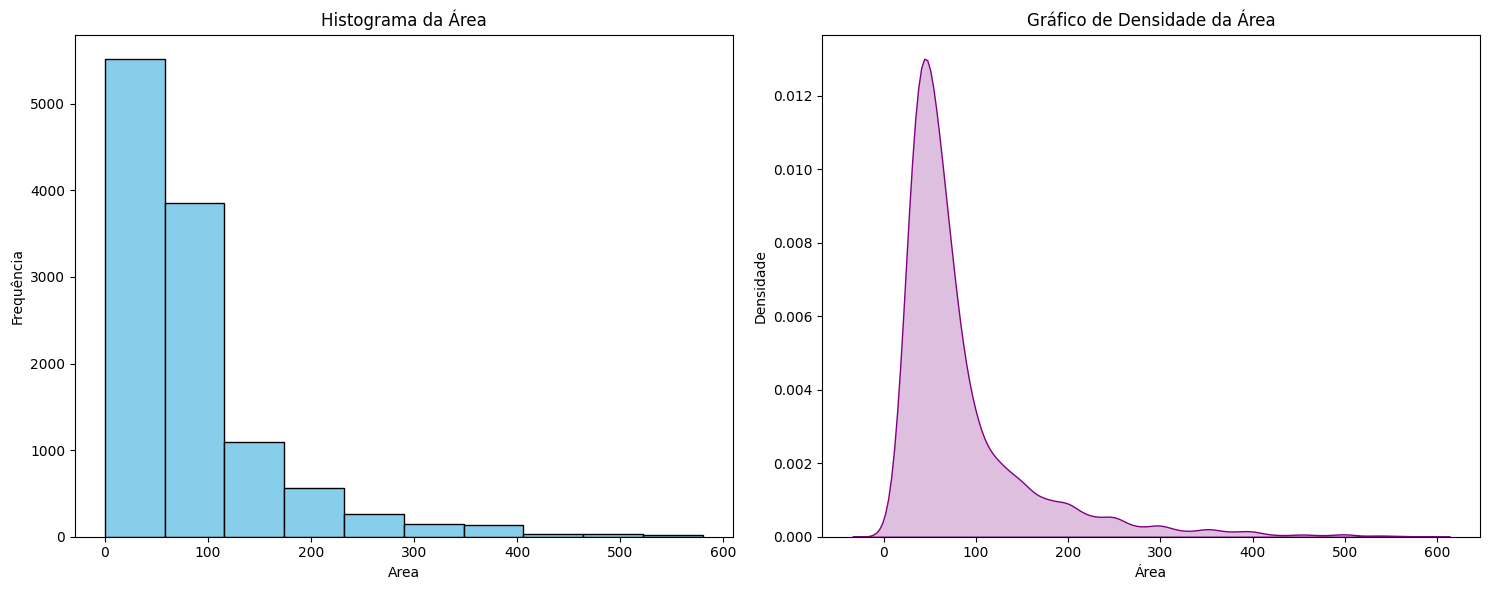

In [51]:

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histograma (usando Matplotlib)
axes[0].hist(df.area, bins=10, color='skyblue', edgecolor='black')
axes[0].set_title('Histograma da Área')
axes[0].set_xlabel('Area')
axes[0].set_ylabel('Frequência')

# Gráfico de Densidade (KDE Plot - usando Seaborn)
sns.kdeplot(data=df, x='area', fill=True, color='purple', ax=axes[1])
axes[1].set_title('Gráfico de Densidade da Área')
axes[1].set_xlabel('Área')
axes[1].set_ylabel('Densidade')

plt.tight_layout()
plt.show()


count    11657.000000
mean        84.655658
std         74.020536
min          0.000000
25%         40.000000
50%         60.000000
75%         96.000000
max        580.000000
Name: area, dtype: float64

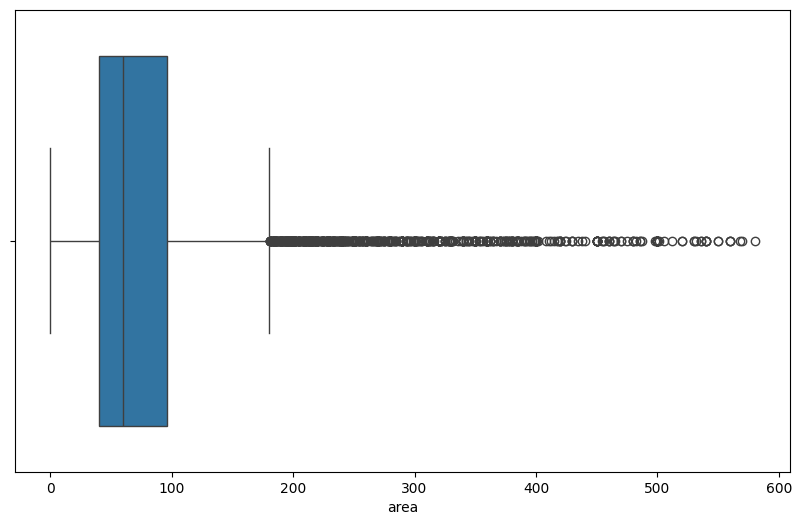

In [52]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['area'])
df.area.describe()

### Verificando a area do menor valor de aluguel


In [53]:
df[df.rent == 500]

,address,district,area,bedrooms,garage,type,rent,total
51,Rua Tanque Velho,Vila Nivi,45,1,0,Casa,500,551
1188,Viela Renaldo Laporta,Vila Aurora (zona Norte),30,1,0,Casa,500,521
4741,Rua Manoel Oliveira Gonçalves,Jardim Jaçanã,30,1,0,Casa,500,509
5901,Rua Manuel José Rodrigues,Sacoma,40,1,0,Casa,500,521
6428,Rua Eugênia S Vitale,Taboão,30,1,0,Studio e kitnet,500,594
7420,Rua Manuel José Rodrigues,Sacoma,20,1,0,Casa,500,521
10559,Rua Arraial de São Bartolomeu,Vila Carmosina,70,2,0,Casa,500,821


## Limpeza dos dados


In [54]:
# Normaliza os nomes dos bairros para padronização
df['district'] = df['district'].str.lower().str.strip()
# Mapeamento manual de variações para nomes oficiais.
# Adicione mais mapeamentos aqui conforme necessário.
mapeamento_nomes = {
    'vila aricanduva': 'Aricanduva',
    'jardim aricanduva': 'Aricanduva',
    'agua branca': 'Água Branca',
    'agua fria': 'Água Fria',
    'agua rasa': 'Água Rasa',
    'bras': 'Brás',
    'santa cecilia': 'Santa Cecília',
    'santa ifigenia': 'Santa Efigênia',
    'chacara santo antonio (zona sul)': 'Chácara Santo Antônio',
    'chacara santo antonio (zona leste)': 'Chácara Santo Antônio',
    'jardim santa cruz (campo grande)': 'Campo Grande',
    'jardim sao paulo(zona norte)': 'Jardim São Paulo',
    'parque são lucas': 'São Lucas',
    'parque da vila prudente': 'Vila Prudente',
    'vila sonia': 'Vila Sônia',
    'bosque da saude': 'Saúde',
    'vila da saude': 'Saúde',
    'jardim da saude': 'Saúde',
    'parque jabaquara': 'Jabaquara',
    'vila parque jabaquara': 'Jabaquara',
    'jardim jabaquara': 'Jabaquara',
    'jardim analia franco': 'Jardim Anália Franco',
    'vila pompéia': 'Pompéia',
    'varzea da barra funda': 'Barra Funda',
    'lapa de baixo': 'Lapa',
    'parque da lapa': 'Lapa',
    'parque residencial da lapa': 'Lapa',
    'jardim das perdizes': 'Perdizes',
    'saco ma': 'Sacomã',
    'jardim vergueiro (sacomã)': 'Sacomã',
    'jardim santa cruz (sacomã)': 'Sacomã',
    'vila matiilde': 'Vila Matilde',
    'centro capital': 'Centro',
    'vila brasilandia': 'Brasilândia',
    'vila pirituba': 'Pirituba',
    'jardim cidade pirituba': 'Pirituba',
    'jardim pirituba': 'Pirituba',
    'republica': 'República',
    'jardim rio pequeno': 'Rio Pequeno',
    'parque da mooca': 'Mooca',
    'vila butanta': 'Butantã',
    'conjunto residencial butantã': 'Butantã',
    'vila brasilandia': 'Brasilândia',
    'vila butanta': 'Butantã',
    'conjunto residencial butantã': 'Butantã',
    'nossa senhora do ó': 'Freguesia do Ó',
    'nossa senhora do o': 'Freguesia do Ó',
    'penha de frança': 'Penha',
    'jardim penha': 'Penha',
    'jardim america da penha': 'Penha',
    'jardim paulistano': 'Jardim Paulista',
    'jardim peri peri': 'Jardim Peri',
    'vila são josé (ipiranga)': 'Ipiranga',
    'vila maria alta': 'Vila Maria',
    'vila maria baixa': 'Vila Maria',
    'jardim vila mariana': 'Vila Mariana',
    'panamby': 'Panamby',
    'super quadra morumbi': 'Morumbi',
    'recanto morumbi': 'Morumbi',
    'jardim parque morumbi': 'Morumbi',
    'parque bairro morumbi': 'Morumbi',
    'jardim independencia (são paulo)': 'Jardim Independência',
    'jardim panaroma (zona leste)': 'Jardim América',
    'brooklin novo': 'Brooklin',
    'brooklin paulista': 'Brooklin',
}

# Aplica o mapeamento para criar a coluna de bairro oficial
df['district'] = df['district'].apply(
    lambda x: mapeamento_nomes.get(x, x.title())
)

### Tratando os outliers


#### Apagar todos os imóveis cuja área é MENOR do que o valor mais barato de aluguel e MAIOR que 120m2


In [55]:
print(df.iloc[7420])
df = df[df.area >= 20]
df = df[df.area < 120]
df.describe()

address     Rua Manuel José Rodrigues
district                       Sacoma
area                               20
bedrooms                            1
garage                              0
type                             Casa
rent                              500
total                             521
Name: 7420, dtype: object


,area,bedrooms,garage,rent,total
count,9294.000000,9294.000000,9294.000000,9294.000000,9294.000000
mean,56.200237,1.691952,0.719389,2519.761244,3189.729611
std,22.630761,0.704710,0.712388,1672.245840,2070.056269
min,20.000000,0.000000,0.000000,500.000000,509.000000
25%,39.000000,1.000000,0.000000,1460.000000,1824.000000
50%,51.000000,2.000000,1.000000,2100.000000,2683.500000
75%,70.000000,2.000000,1.000000,3000.000000,3943.750000
max,119.000000,5.000000,6.000000,25000.000000,26710.000000


count    9294.000000
mean       56.200237
std        22.630761
min        20.000000
25%        39.000000
50%        51.000000
75%        70.000000
max       119.000000
Name: area, dtype: float64

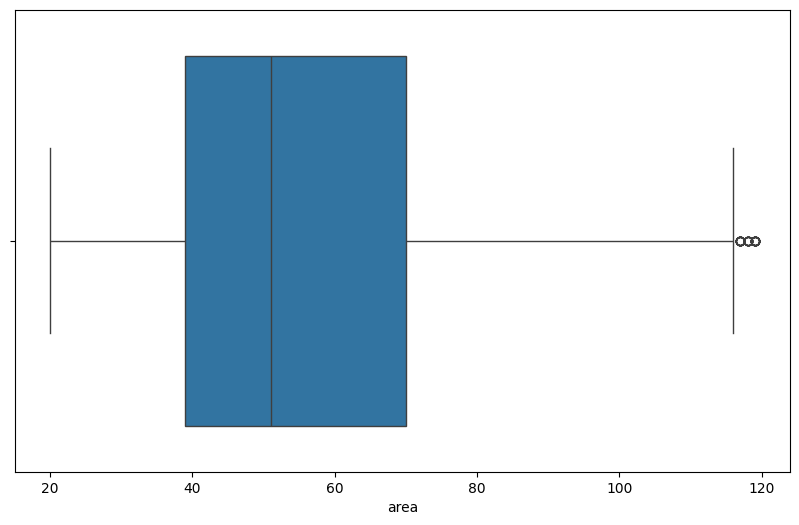

In [56]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['area'])
df.area.describe()

### Engenharia de Features


### Removendo Coluna "rent"


In [57]:
df_clean = df.drop(columns=['rent','address'])

### Criando coluna "price_m2"


In [58]:
df_clean["price_m2"] = df_clean["total"] / df_clean["area"]
df_clean.price_m2.describe()

count    9294.000000
mean       60.371835
std        36.657964
min         9.650000
25%        36.808292
50%        50.782468
75%        73.335882
max      1112.916667
Name: price_m2, dtype: float64

### Criando coluna "price_level"


In [59]:
bins = [9, 50, 70,90 , 1115]
labels = ["Baixo", "Medio", "Alto", "Muito Alto"]

df_clean["price_level"] = pd.cut(
    df_clean["price_m2"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

In [60]:
df_clean

,district,area,bedrooms,garage,type,total,price_m2,price_level
0,Belenzinho,21,1,0,Studio e kitnet,2939,139.952381,Muito Alto
3,Vila Ré,56,2,2,Casa em condomínio,1954,34.892857,Baixo
5,Brás,50,2,1,Apartamento,4587,91.740000,Muito Alto
6,Brooklin,72,2,1,Apartamento,5187,72.041667,Alto
7,Centro,26,1,0,Studio e kitnet,2244,86.307692,Alto
...,...,...,...,...,...,...,...,...
11645,Santo Amaro,70,2,0,Apartamento,3116,44.514286,Baixo
11652,Santo Amaro,94,2,1,Apartamento,5778,61.468085,Medio
11654,Jardim Caravelas,84,1,2,Apartamento,5467,65.083333,Medio
11655,Jardim Fonte Do Morumbi,76,1,0,Apartamento,10200,134.210526,Muito Alto


### Distribuição de Imoveis Preço Total


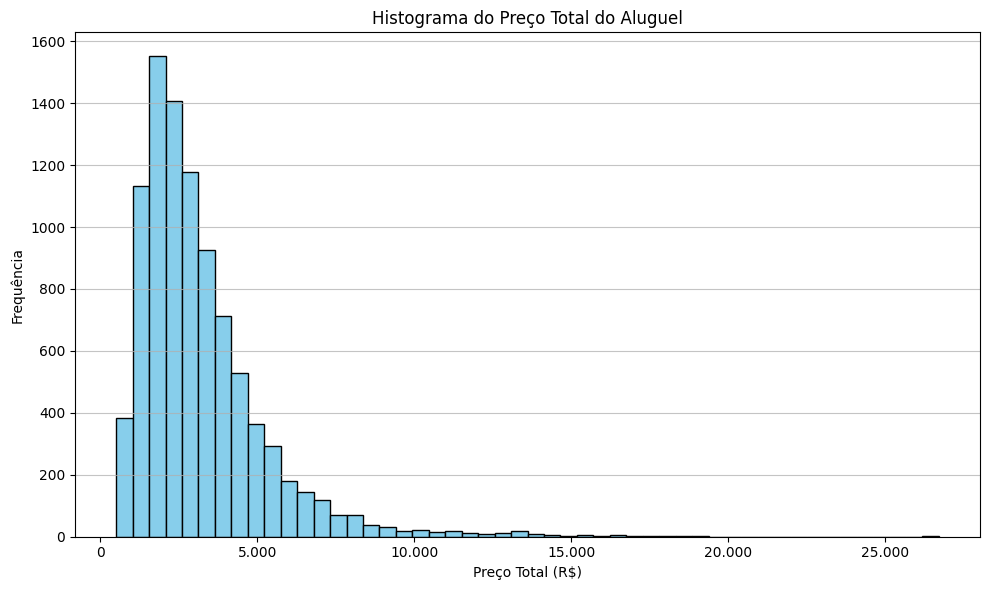

In [61]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df_clean['total'], bins=50, color='skyblue', edgecolor='black')

ax.set_title('Histograma do Preço Total do Aluguel')
ax.set_xlabel('Preço Total (R$)')    
ax.set_ylabel('Frequência')         
ax.grid(axis='y', alpha=0.75)

ax.get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x).replace(",", "."))
)

plt.tight_layout()

### Distribuição de Imoveis Preço m2


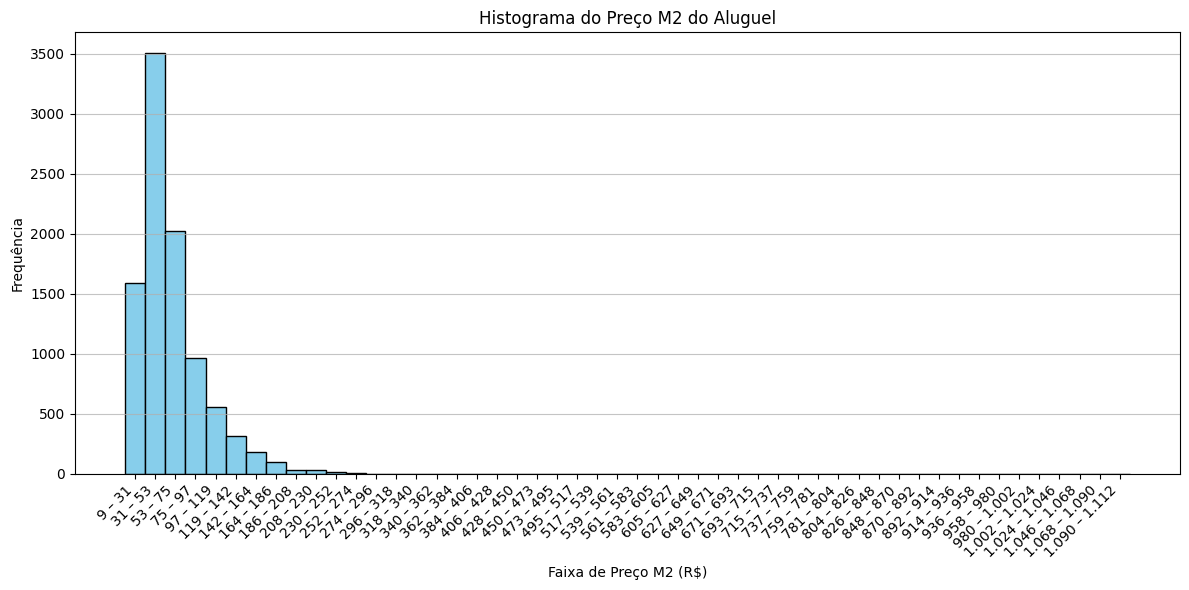

In [62]:
fig, ax = plt.subplots(figsize=(12, 6))

counts, bins, patches = ax.hist(
    df_clean['price_m2'], bins=50, color='skyblue', edgecolor='black'
)

bin_labels = [f"{int(bins[i]):,} – {int(bins[i+1]):,}".replace(",", ".")
              for i in range(len(bins)-1)]

bin_centers = (bins[:-1] + bins[1:]) / 2
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels, rotation=45, ha="right")

ax.set_title("Histograma do Preço M2 do Aluguel")
ax.set_xlabel("Faixa de Preço M2 (R$)")
ax.set_ylabel("Frequência")
ax.grid(axis="y", alpha=0.75)

plt.tight_layout()
plt.show()


Mapear bairros para cada faixa


In [63]:
bins = [9, 50, 70,90 , 1115]
labels = ["Baixo", "Médio", "Alto", "Muito Alto"]

df_clean["faixa_preco_m2"] = pd.cut(df_clean["price_m2"], bins=bins, labels=labels, include_lowest=True)

# Contagem de imóveis por distrito dentro de cada faixa
concentracao = df_clean.groupby(["faixa_preco_m2", "district"]).size().reset_index(name="quantidade")

# Para cada faixa, pegar o distrito com maior concentração
top_distritos = concentracao.loc[concentracao.groupby("faixa_preco_m2")["quantidade"].idxmax()]

top_distritos


,faixa_preco_m2,district,quantidade
21,Baixo,Bela Vista,94
1052,Médio,Bela Vista,81
2083,Alto,Bela Vista,66
3944,Muito Alto,Vila Mariana,95


### Analisando a relação entre Bairro e Nível de Preço


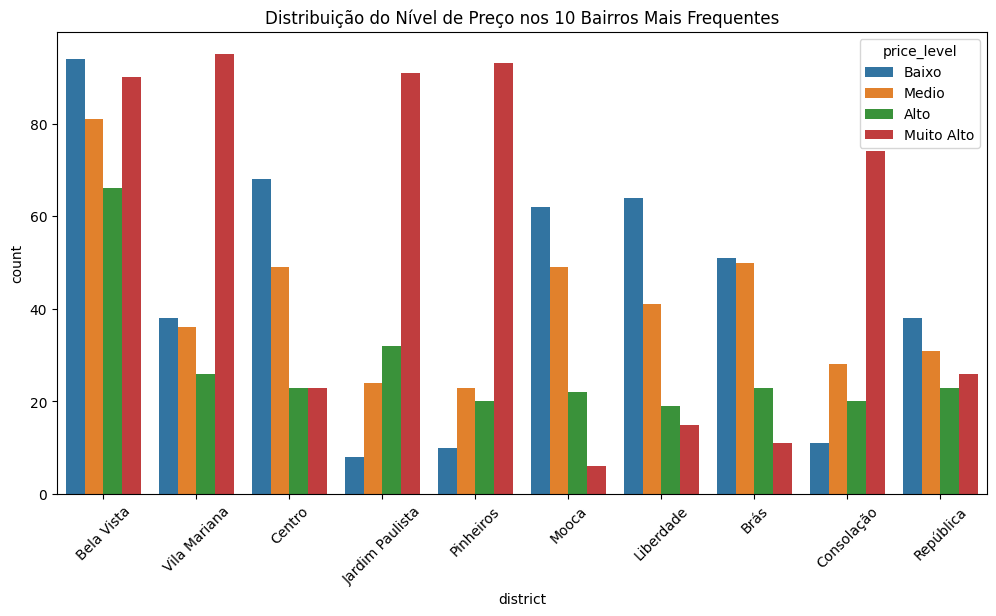

In [64]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_clean, x='district', hue='price_level', order=df_clean['district'].value_counts().iloc[:10].index)
plt.title('Distribuição do Nível de Preço nos 10 Bairros Mais Frequentes')
plt.xticks(rotation=45)
plt.show()

### Analisando a relação entre Tipo de Imóvel e Nível de Preço


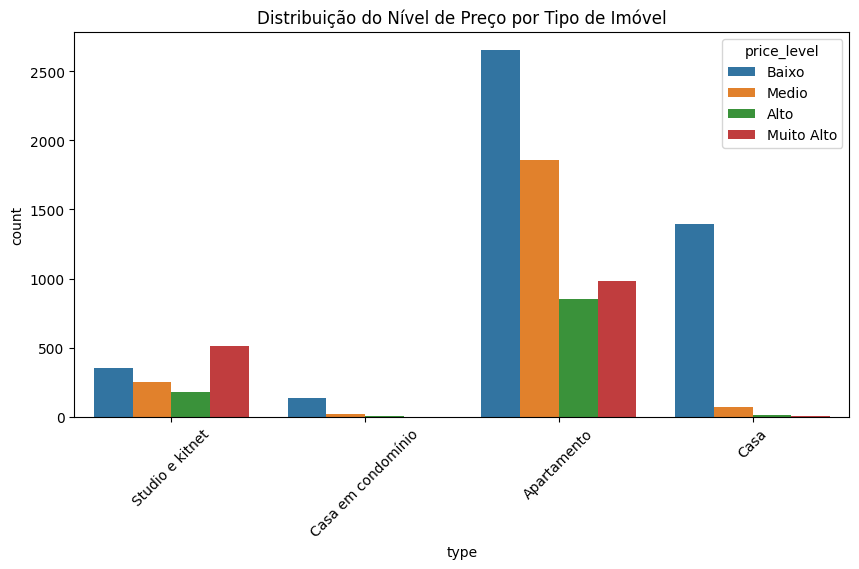

In [65]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_clean, x='type', hue='price_level')
plt.title('Distribuição do Nível de Preço por Tipo de Imóvel')
plt.xticks(rotation=45)
plt.show()

Mapa de correlação (heatmap) para identificar quais variáveis impactam mais no preço do aluguel.


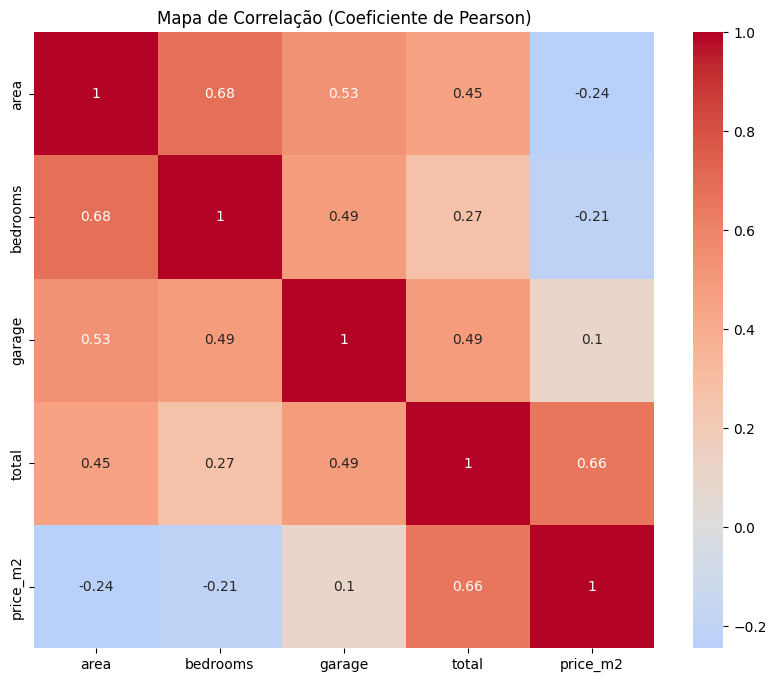

In [66]:
numeric_cols = df_clean.select_dtypes(include=["int64", "float64"])

corr = numeric_cols.corr(method="pearson")

# Plotar heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Mapa de Correlação (Coeficiente de Pearson)")
plt.show()


Clusterização de bairros
Usar KMeans ou DBSCAN para agrupar bairros com perfis semelhantes de aluguel/m².


In [67]:
# bairros = df_clean.groupby("district").agg({
#     "price_m2": "mean",
#     "total": "mean",
#     "area": "mean"
# }).reset_index()

# # 4. Selecionar features para clusterização
# X = bairros[["price_m2", "total", "area"]]

# # Normalizar os dados
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 5. KMeans
# kmeans = KMeans(n_clusters=4, random_state=42)  # defina n_clusters
# bairros["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

# dbscan = DBSCAN(eps=1.2, min_samples=3)
# bairros["cluster_dbscan"] = dbscan.fit_predict(X_scaled)

# # 7. Visualizar clusters (exemplo com 2 variáveis)
# plt.scatter(bairros["price_m2"], bairros["total"],
#             c=bairros["cluster_kmeans"], cmap="viridis")
# plt.xlabel("Valor médio m²")
# plt.ylabel("Aluguel médio")
# plt.title("Clusters de bairros - KMeans")
# plt.show()

# print(bairros.head())

Comparar price_level entre imóveis com 1, 2, 3 e 4 quartos.


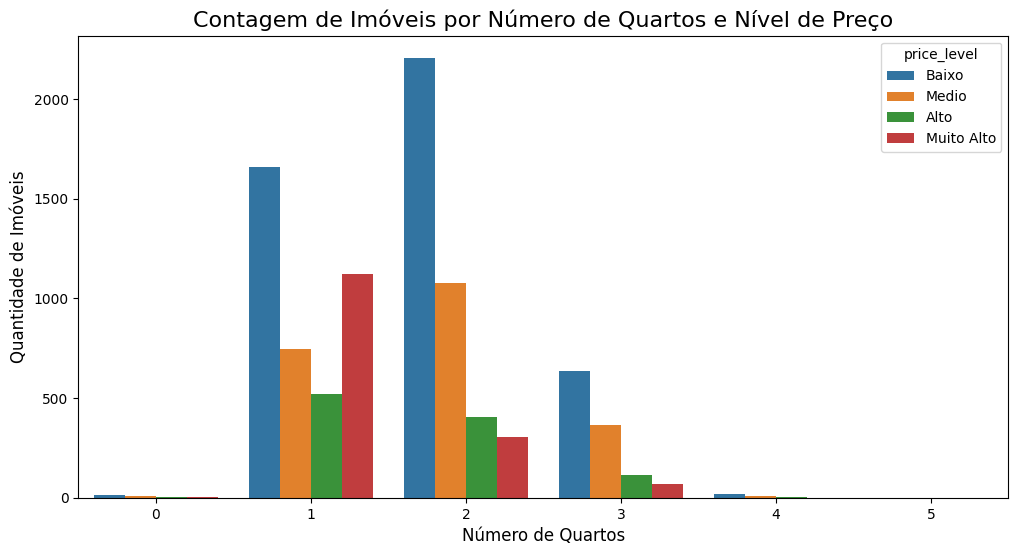

In [68]:
quartos_ordenados = sorted(df_clean['bedrooms'].unique())
quartos_ordenados = [q for q in quartos_ordenados if q <= 6] # Exemplo: limita até 6 quartos

plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_clean,
    x='bedrooms',
    hue='price_level',  # <<< CORREÇÃO: Usar a variável categórica 'price_level'
    order=quartos_ordenados # <<< Garante a ordem correta no eixo x
)

# Título corrigido para corresponder ao gráfico
plt.title('Contagem de Imóveis por Número de Quartos e Nível de Preço', fontsize=16)
plt.xlabel('Número de Quartos', fontsize=12)
plt.ylabel('Quantidade de Imóveis', fontsize=12)
plt.xticks(rotation=0) # Não precisa de rotação para poucos números
plt.show()

Impacto da vaga de garagem no preço/m².


In [69]:
df_garagem = df_clean.copy()

# Corrige a escala do preço/m² para Reais (R$)
df_garagem['price_m2'] = df_garagem['price_m2']

# Função para formatar o eixo Y como moeda
def format_currency(x, pos):
    return f'R$ {int(x):,}'.replace(',', '.')

formatter = FuncFormatter(format_currency)

# Para focar a análise, vamos ver a distribuição de vagas de garagem
print("--- Contagem de Imóveis por Número de Vagas ---")
print(df_garagem['garage'].value_counts())

--- Contagem de Imóveis por Número de Vagas ---
garage
1    4231
0    3887
2    1098
3      63
4       8
5       4
6       3
Name: count, dtype: int64


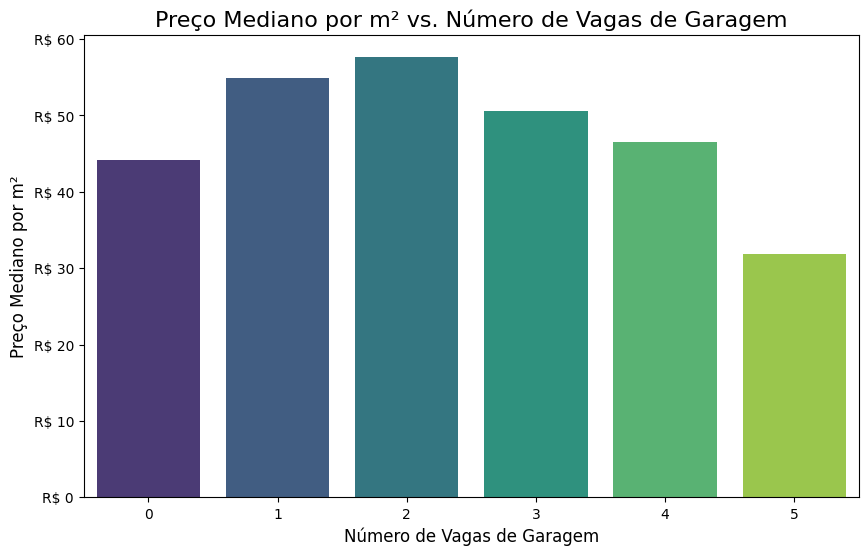


--- Preço Mediano por m² por Vaga de Garagem ---
   garage   price_m2
0       0  44.192308
1       1  54.951613
2       2  57.627037
3       3  50.520000
4       4  46.585885
5       5  31.881978


In [70]:
vagas_comuns = [0, 1, 2, 3, 4, 5]
df_filtrado_vagas = df_garagem[df_garagem['garage'].isin(vagas_comuns)]

# Agrupar por número de vagas e calcular a mediana do preço/m²
preco_por_vaga = df_filtrado_vagas.groupby('garage')['price_m2'].median().reset_index()

# Visualização com Barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=preco_por_vaga, x='garage', y='price_m2', palette='viridis')

plt.title('Preço Mediano por m² vs. Número de Vagas de Garagem', fontsize=16)
plt.xlabel('Número de Vagas de Garagem', fontsize=12)
plt.ylabel('Preço Mediano por m²', fontsize=12)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

# Imprimir a tabela para referência
print("\n--- Preço Mediano por m² por Vaga de Garagem ---")
print(preco_por_vaga)

#### Removendo linhas com NaN na feature target


In [71]:
df_clean = df_clean.dropna(subset=["price_level"])
df_clean

,district,area,bedrooms,garage,type,total,price_m2,price_level,faixa_preco_m2
0,Belenzinho,21,1,0,Studio e kitnet,2939,139.952381,Muito Alto,Muito Alto
3,Vila Ré,56,2,2,Casa em condomínio,1954,34.892857,Baixo,Baixo
5,Brás,50,2,1,Apartamento,4587,91.740000,Muito Alto,Muito Alto
6,Brooklin,72,2,1,Apartamento,5187,72.041667,Alto,Alto
7,Centro,26,1,0,Studio e kitnet,2244,86.307692,Alto,Alto
...,...,...,...,...,...,...,...,...,...
11645,Santo Amaro,70,2,0,Apartamento,3116,44.514286,Baixo,Baixo
11652,Santo Amaro,94,2,1,Apartamento,5778,61.468085,Medio,Médio
11654,Jardim Caravelas,84,1,2,Apartamento,5467,65.083333,Medio,Médio
11655,Jardim Fonte Do Morumbi,76,1,0,Apartamento,10200,134.210526,Muito Alto,Muito Alto


### Coeficiente de Person

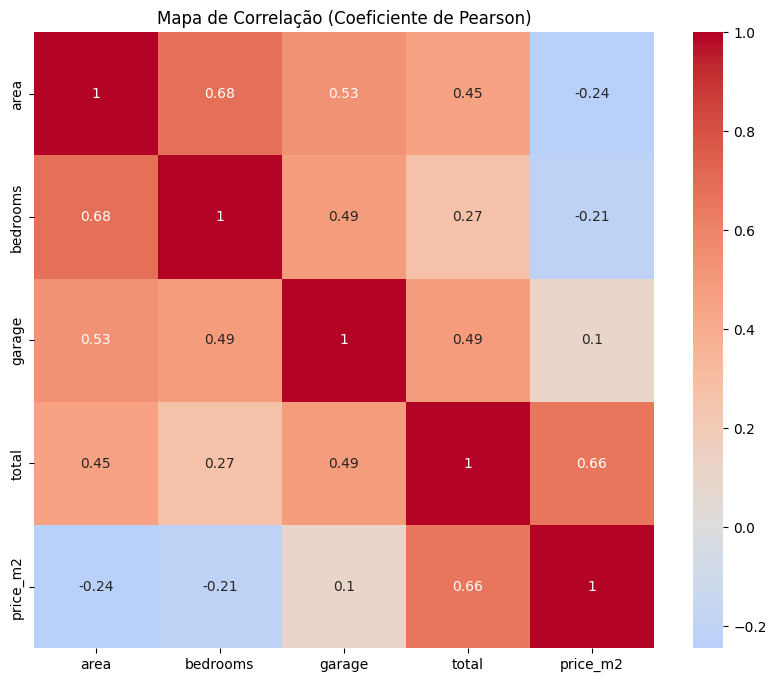

In [72]:
numeric_cols = df_clean.select_dtypes(include=["int64", "float64"])

corr = numeric_cols.corr(method="pearson")

# Plotar heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Mapa de Correlação (Coeficiente de Pearson)")
plt.show()


#### Verificando a distribuição


price_level
Baixo         4537
Medio         2209
Muito Alto    1500
Alto          1048
Name: count, dtype: int64


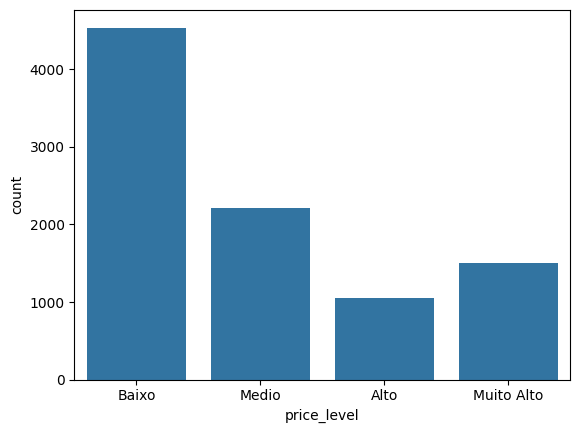

In [73]:
sns.countplot(x = df_clean['price_level'])
print(df_clean["price_level"].value_counts())

### Mapa de Calor Imoveis por Número de Quartos


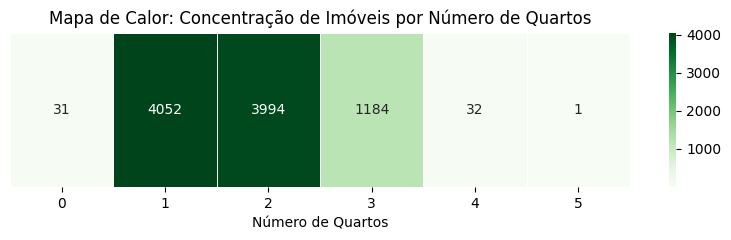

In [74]:
bedroom_counts = df_clean['bedrooms'].value_counts().reset_index()
bedroom_counts.columns = ['bedrooms', 'count']
bedroom_counts = bedroom_counts.sort_values('bedrooms')

heatmap_1d_data = bedroom_counts.set_index('bedrooms').T

# Gerando o mapa de calor 1D
plt.figure(figsize=(10, 2))
sns.heatmap(heatmap_1d_data, cmap="Greens", annot=True, fmt=".0f", linewidths=.5)
plt.title('Mapa de Calor: Concentração de Imóveis por Número de Quartos')
plt.xlabel('Número de Quartos')
plt.ylabel('')
plt.yticks([])
plt.savefig('heatmap_imoveis_apenas_quartos.png') # Salva a imagem
plt.show()

## Divisão entre previsores (X) e classe (y)


In [75]:
target = "price_level"
X = df_clean.drop(columns=[target, 'price_m2', 'total','faixa_preco_m2'])
y = df_clean[target]

print("Features utilizadas para o treinamento:", X.columns.tolist())

Features utilizadas para o treinamento: ['district', 'area', 'bedrooms', 'garage', 'type']


#### Separando variaveis entre numericas e categoricas


In [76]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [77]:
# num_features = ["area"]
# cat_features.extend(['garage',"bedrooms"])
# cat_features

## Escalonamento dos valores e Codificação de variáveis categóricas


In [78]:
ohe_enc = OneHotEncoder(sparse_output=False)
scaler_std = StandardScaler()

X_num_std = scaler_std.fit_transform(df[num_features])
X_nom = ohe_enc.fit_transform(df[cat_features]) if cat_features else np.empty((len(df),0))

X_final = np.hstack([X_num_std, X_nom])
X_final

array([[-1.55549921, -0.98194824, -1.00988167, ...,  0.        ,
         0.        ,  1.        ],
       [-0.00884846,  0.43715096,  1.79772834, ...,  0.        ,
         1.        ,  0.        ],
       [-0.27398859,  0.43715096,  0.39392333, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.22847213, -0.98194824,  1.79772834, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.87495196, -0.98194824, -1.00988167, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.37741269,  1.85625015,  0.39392333, ...,  1.        ,
         0.        ,  0.        ]], shape=(9294, 1038))

## Divisão da Base em treinamento, teste


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

### Transformer para converter sparse -> dense (para Naive Bayes)


In [80]:
from sklearn.base import BaseEstimator, TransformerMixin
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X_final, y=None):
        return self
    def transform(self, X_final, y=None):
        return X_final.toarray()

## Invocando modelos


In [81]:
models_default = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "NeuralNetwork": MLPClassifier(), 
    "NaiveBayes": GaussianNB()
}

models_best_parameters = {
    "LogisticRegression": LogisticRegression(C= 10.0, max_iter= 500, solver= 'lbfgs'),
    "RandomForest": RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 100),
    "SVM": SVC(C= 10, gamma= 'scale', kernel= 'rbf'),
    "KNN": KNeighborsClassifier(metric= 'euclidean', n_neighbors= 7, weights= 'distance'),
    "DecisionTree": DecisionTreeClassifier(max_depth= 20, min_samples_leaf= 1, min_samples_split= 5),
    "NeuralNetwork": MLPClassifier(activation= 'tanh', alpha= 0.0001, hidden_layer_sizes= (100,)), 
    "NaiveBayes": GaussianNB()
}

### Dataset de avaliação de modelos


In [82]:
resultados = []

# Treinamento sem PCA com SMOTE


In [83]:
sm = SMOTE(random_state=42)
sm.fit(X_train, y_train)

,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5


### Treinamento e validação



==================== LogisticRegression ====================
✨ Novo melhor modelo encontrado: LogisticRegression com acurácia de 0.6428!


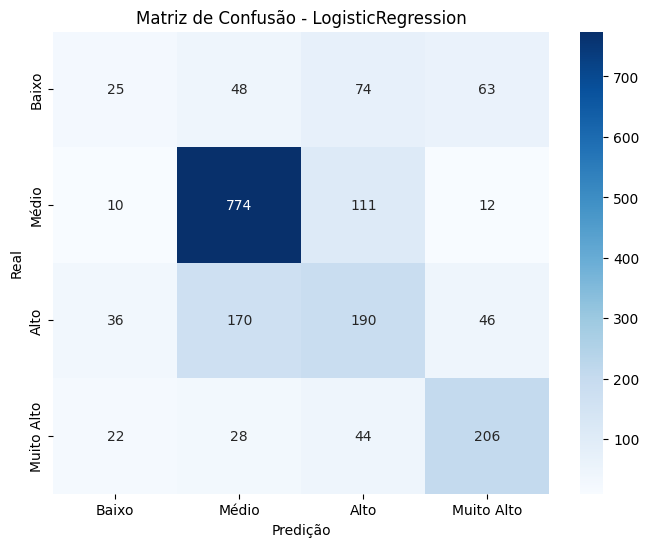


Relatório de Classificação para LogisticRegression:
              precision    recall  f1-score   support

       Baixo       0.27      0.12      0.17       210
       Médio       0.76      0.85      0.80       907
        Alto       0.45      0.43      0.44       442
  Muito Alto       0.63      0.69      0.66       300

    accuracy                           0.64      1859
   macro avg       0.53      0.52      0.52      1859
weighted avg       0.61      0.64      0.62      1859

Tempo de treinamento: 27.2787 segundos

==================== RandomForest ====================


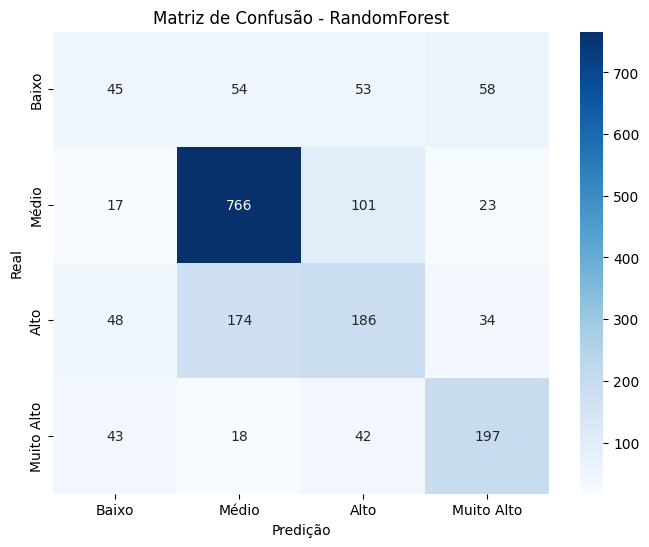


Relatório de Classificação para RandomForest:
              precision    recall  f1-score   support

       Baixo       0.29      0.21      0.25       210
       Médio       0.76      0.84      0.80       907
        Alto       0.49      0.42      0.45       442
  Muito Alto       0.63      0.66      0.64       300

    accuracy                           0.64      1859
   macro avg       0.54      0.53      0.54      1859
weighted avg       0.62      0.64      0.63      1859

Tempo de treinamento: 4.5483 segundos

==================== SVM ====================


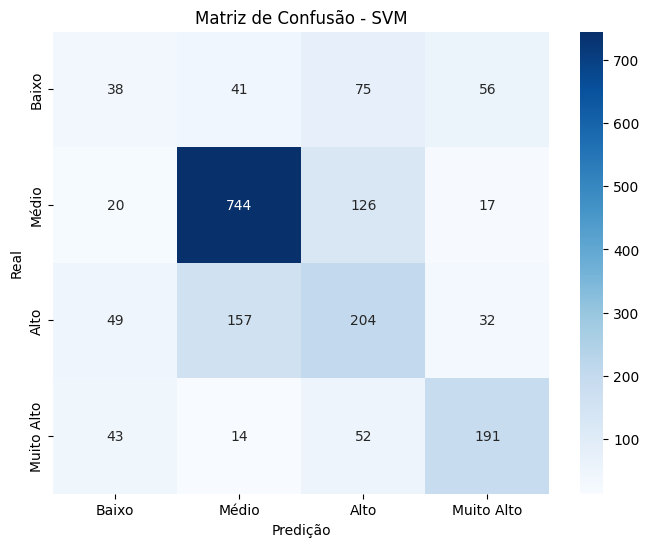


Relatório de Classificação para SVM:
              precision    recall  f1-score   support

       Baixo       0.25      0.18      0.21       210
       Médio       0.78      0.82      0.80       907
        Alto       0.45      0.46      0.45       442
  Muito Alto       0.65      0.64      0.64       300

    accuracy                           0.63      1859
   macro avg       0.53      0.52      0.53      1859
weighted avg       0.62      0.63      0.62      1859

Tempo de treinamento: 30.9319 segundos

==================== KNN ====================


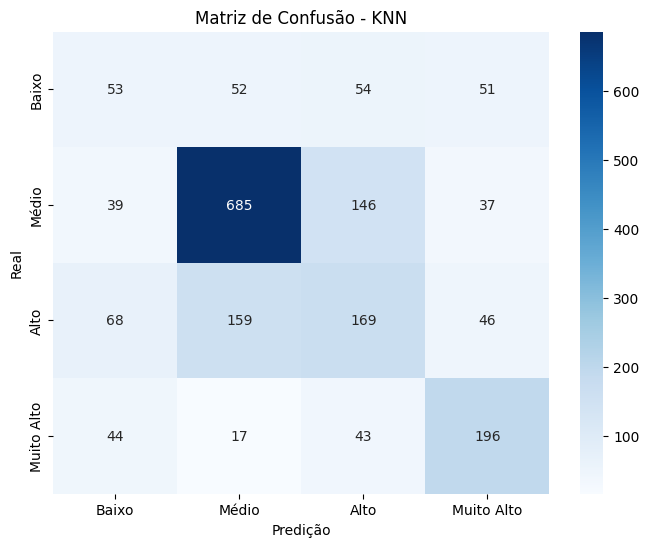


Relatório de Classificação para KNN:
              precision    recall  f1-score   support

       Baixo       0.26      0.25      0.26       210
       Médio       0.75      0.76      0.75       907
        Alto       0.41      0.38      0.40       442
  Muito Alto       0.59      0.65      0.62       300

    accuracy                           0.59      1859
   macro avg       0.50      0.51      0.51      1859
weighted avg       0.59      0.59      0.59      1859

Tempo de treinamento: 0.0083 segundos

==================== DecisionTree ====================


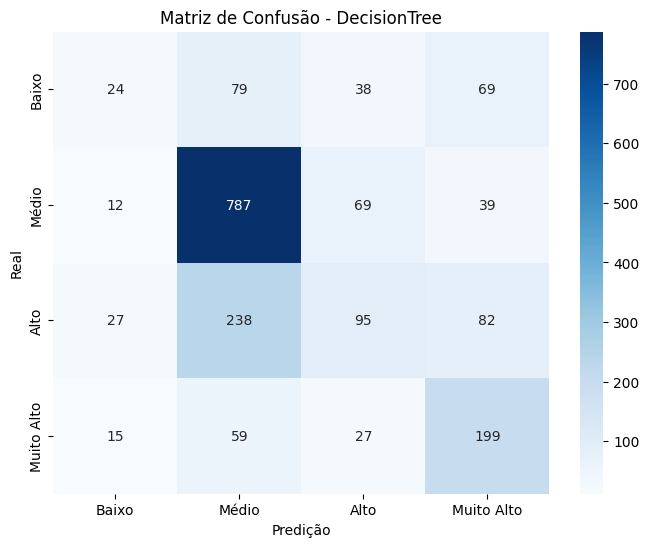


Relatório de Classificação para DecisionTree:
              precision    recall  f1-score   support

       Baixo       0.31      0.11      0.17       210
       Médio       0.68      0.87      0.76       907
        Alto       0.41      0.21      0.28       442
  Muito Alto       0.51      0.66      0.58       300

    accuracy                           0.59      1859
   macro avg       0.48      0.47      0.45      1859
weighted avg       0.55      0.59      0.55      1859

Tempo de treinamento: 0.3783 segundos

==================== NeuralNetwork ====================


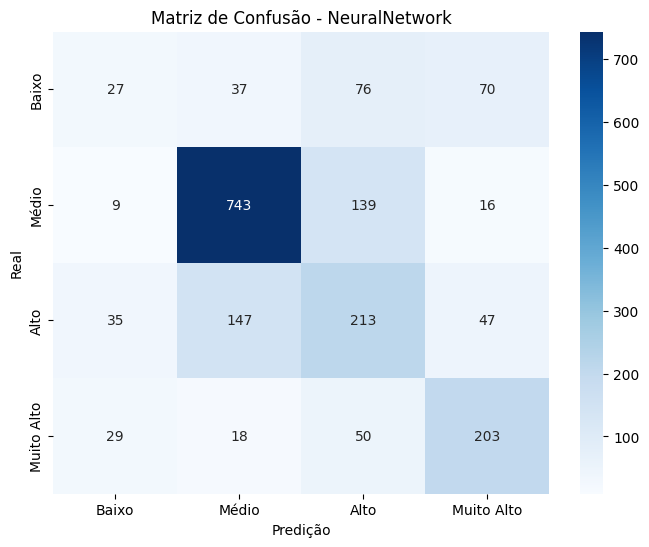


Relatório de Classificação para NeuralNetwork:
              precision    recall  f1-score   support

       Baixo       0.27      0.13      0.17       210
       Médio       0.79      0.82      0.80       907
        Alto       0.45      0.48      0.46       442
  Muito Alto       0.60      0.68      0.64       300

    accuracy                           0.64      1859
   macro avg       0.53      0.53      0.52      1859
weighted avg       0.62      0.64      0.62      1859

Tempo de treinamento: 32.0831 segundos

==================== NaiveBayes ====================


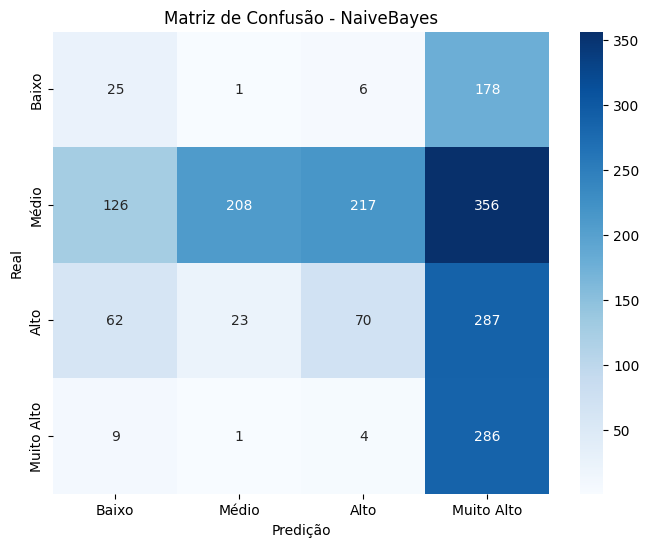


Relatório de Classificação para NaiveBayes:
              precision    recall  f1-score   support

       Baixo       0.11      0.12      0.12       210
       Médio       0.89      0.23      0.36       907
        Alto       0.24      0.16      0.19       442
  Muito Alto       0.26      0.95      0.41       300

    accuracy                           0.32      1859
   macro avg       0.37      0.37      0.27      1859
weighted avg       0.55      0.32      0.30      1859

Tempo de treinamento: 0.0937 segundos


In [84]:
import warnings
warnings.filterwarnings('ignore') 

param_grids = {
    "LogisticRegression": {
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [500, 1000]
    },
    "RandomForest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    "DecisionTree": {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "NeuralNetwork": {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001]
    }
}

# Modificando o loop de treinamento para usar GridSearchCV
melhor_pipeline = None
nome_melhor_modelo = ""
melhor_score = 0.0
resultados = []

for name, model in models_best_parameters.items():
    print(f"\n==================== {name} ====================")
    
    # Ignorar NaiveBayes pois não tem hiperparâmetros para otimizar
    # if name == "NaiveBayes":
    #     grid_search = model
    # else:
    #     # Configurar e executar GridSearchCV
    #     grid_search = GridSearchCV(
    #         estimator=model,
    #         param_grid=param_grids[name],
    #         cv=5,
    #         n_jobs=-1,
    #         scoring='accuracy',
    #         verbose=1
    #     )
    
    # Treinamento com medição de tempo
    inicio = time.time()
    model.fit(X_train, y_train)
    fim = time.time()
    tempo_treino = fim - inicio

    # Previsões usando os melhores parâmetros
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)

    # Atualizar melhor modelo se necessário
    if acc_test > melhor_score:
        print(f"✨ Novo melhor modelo encontrado: {name} com acurácia de {acc_test:.4f}!")
        melhor_score = acc_test
        melhor_pipeline = model
        nome_melhor_modelo = name

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusão - {name}')
    plt.show()

    # Imprimir resultados detalhados
    print(f"\nRelatório de Classificação para {name}:")
    print(classification_report(y_test, y_pred_test, target_names=labels))
    print(f"Tempo de treinamento: {tempo_treino:.4f} segundos")
    
    # if name != "NaiveBayes":
    #     print("\nMelhores parâmetros encontrados:")
    #     print(f"Melhor score CV: {model.best_score_:.4f}")
    
    print("=" * 52)

    # Armazenar resultados
    resultados.append({
        "Modelo": name,
        "Acurácia Teste": acc_test,
        "Tempo Treino (s)": round(tempo_treino, 4),
    })

### Exibindo Resultados


In [85]:
df_resultados = pd.DataFrame(resultados)
df_resultados

,Modelo,Acurácia Teste,Tempo Treino (s)
0,LogisticRegression,0.642819,27.2787
1,RandomForest,0.642281,4.5483
2,SVM,0.633136,30.9319
3,KNN,0.593330,0.0083
4,DecisionTree,0.594406,0.3783
5,NeuralNetwork,0.637977,32.0831
6,NaiveBayes,0.316837,0.0937


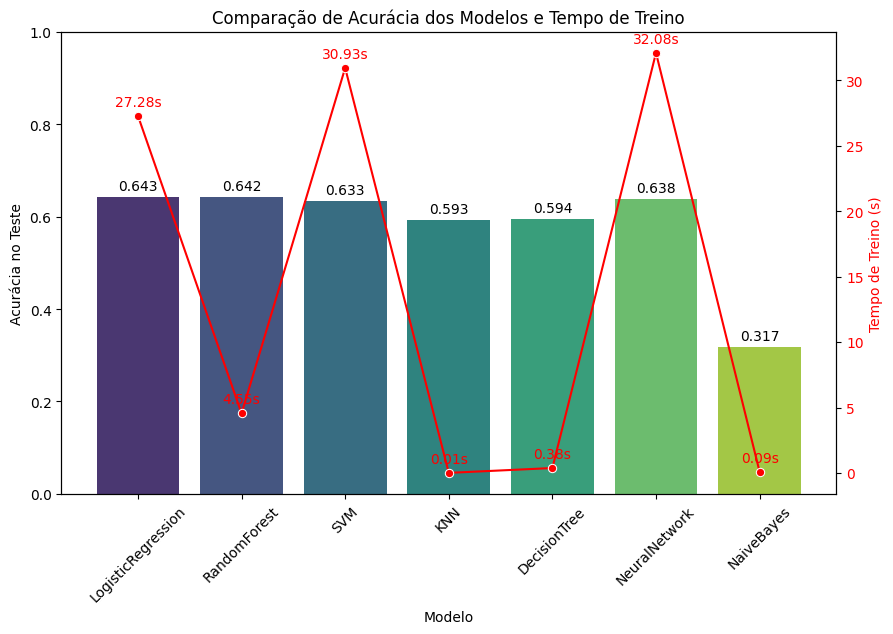

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

# Barplot da acurácia
sns.barplot(data=df_resultados, x='Modelo', y='Acurácia Teste', palette='viridis', ax=ax1, hue='Modelo', legend=False)
ax1.set_ylabel('Acurácia no Teste')
ax1.set_xlabel('Modelo')
ax1.set_ylim(0, 1)
ax1.set_title('Comparação de Acurácia dos Modelos e Tempo de Treino')
ax1.tick_params(axis='x', rotation=45)

# Adiciona os valores em cima das barras de acurácia
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.3f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                 textcoords='offset points')

# Cria um segundo eixo y para o tempo de treino
ax2 = ax1.twinx()
line = sns.lineplot(data=df_resultados, x='Modelo', y='Tempo Treino (s)', marker='o', color='red', ax=ax2)
ax2.set_ylabel('Tempo de Treino (s)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adiciona os valores do tempo de treino acima dos pontos
for x, y in zip(df_resultados['Modelo'], df_resultados['Tempo Treino (s)']):
    ax2.annotate(f'{y:.2f}s', (x, y), color='red', fontsize=10, ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.show()

## Salvando Transformers e modelo


In [87]:
if melhor_pipeline is not None:
    # Cria diretório para modelos se não existir
    import os
    model_dir = "modelos"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    # Salvando o melhor modelo
    joblib.dump(melhor_pipeline, f"{model_dir}/{nome_melhor_modelo}.pkl")
    
    # Salvando os transformers
    joblib.dump(scaler_std, f"{model_dir}/scaler.pkl")
    joblib.dump(ohe_enc, f"{model_dir}/encoder.pkl")
    
    print(f"\n✅ Modelo e transformers salvos com sucesso:")
    print(f"   - Modelo: '{nome_melhor_modelo}_smote.pkl'")
    print(f"   - Scaler: 'scaler.pkl'")
    print(f"   - Encoder: 'encoder.pkl'")
    print(f"   Acurácia no teste: {melhor_score:.4f}")
    
    # Salvando informações sobre features para referência futura
    feature_info = {
        'numeric_features': num_features,
        'categorical_features': cat_features,
        'target_labels': labels  # Usando os labels definidos anteriormente
    }
    
    import json
    with open(f"{model_dir}/feature_info.json", 'w') as f:
        json.dump(feature_info, f, indent=4)
    
    print("\nℹ️ Informações sobre features salvas em 'feature_info.json'")
else:
    print("\n❌ Nenhum modelo foi treinado ou salvo.")


✅ Modelo e transformers salvos com sucesso:
   - Modelo: 'LogisticRegression_smote.pkl'
   - Scaler: 'scaler.pkl'
   - Encoder: 'encoder.pkl'
   Acurácia no teste: 0.6428

ℹ️ Informações sobre features salvas em 'feature_info.json'


# Treinamento sem PCA com TOMEK

In [88]:
tml = TomekLinks()
tml.fit(X_train, y_train)

,sampling_strategy,'auto'
,n_jobs,None


### Treinamento


==================== LogisticRegression ====================
✨ Novo melhor modelo encontrado: LogisticRegression com acurácia de 0.6428!


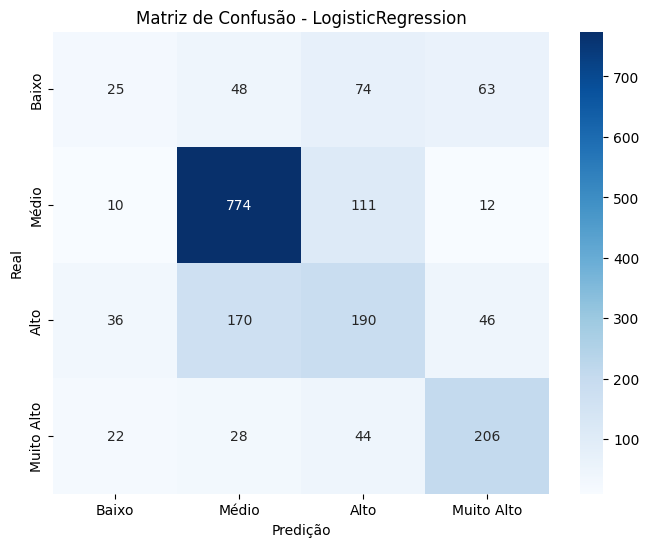


Relatório de Classificação para LogisticRegression:
              precision    recall  f1-score   support

       Baixo       0.27      0.12      0.17       210
       Médio       0.76      0.85      0.80       907
        Alto       0.45      0.43      0.44       442
  Muito Alto       0.63      0.69      0.66       300

    accuracy                           0.64      1859
   macro avg       0.53      0.52      0.52      1859
weighted avg       0.61      0.64      0.62      1859

Tempo de treinamento: 27.8705 segundos

==================== RandomForest ====================


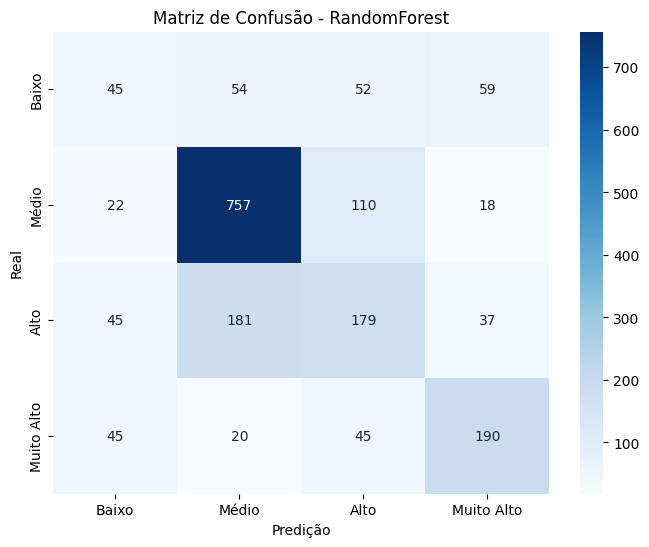


Relatório de Classificação para RandomForest:
              precision    recall  f1-score   support

       Baixo       0.29      0.21      0.25       210
       Médio       0.75      0.83      0.79       907
        Alto       0.46      0.40      0.43       442
  Muito Alto       0.62      0.63      0.63       300

    accuracy                           0.63      1859
   macro avg       0.53      0.52      0.52      1859
weighted avg       0.61      0.63      0.62      1859

Tempo de treinamento: 5.1016 segundos

==================== SVM ====================


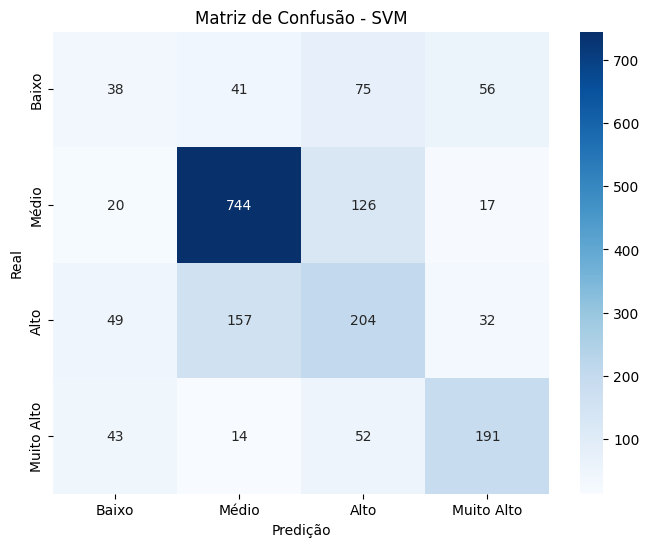


Relatório de Classificação para SVM:
              precision    recall  f1-score   support

       Baixo       0.25      0.18      0.21       210
       Médio       0.78      0.82      0.80       907
        Alto       0.45      0.46      0.45       442
  Muito Alto       0.65      0.64      0.64       300

    accuracy                           0.63      1859
   macro avg       0.53      0.52      0.53      1859
weighted avg       0.62      0.63      0.62      1859

Tempo de treinamento: 30.3346 segundos

==================== KNN ====================


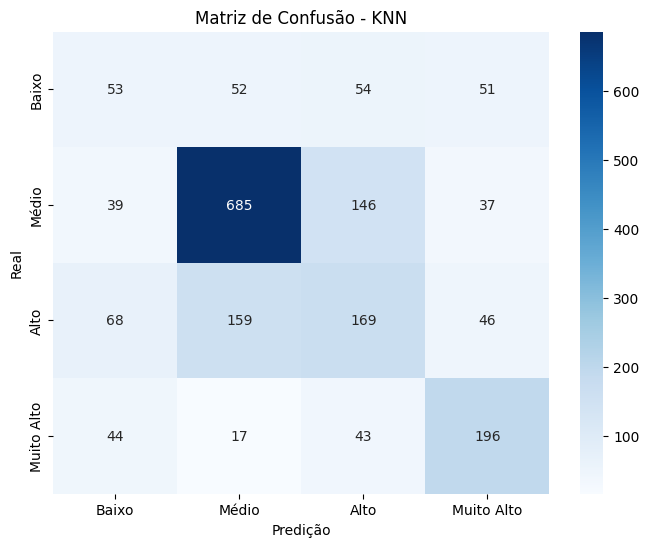


Relatório de Classificação para KNN:
              precision    recall  f1-score   support

       Baixo       0.26      0.25      0.26       210
       Médio       0.75      0.76      0.75       907
        Alto       0.41      0.38      0.40       442
  Muito Alto       0.59      0.65      0.62       300

    accuracy                           0.59      1859
   macro avg       0.50      0.51      0.51      1859
weighted avg       0.59      0.59      0.59      1859

Tempo de treinamento: 0.0087 segundos

==================== DecisionTree ====================


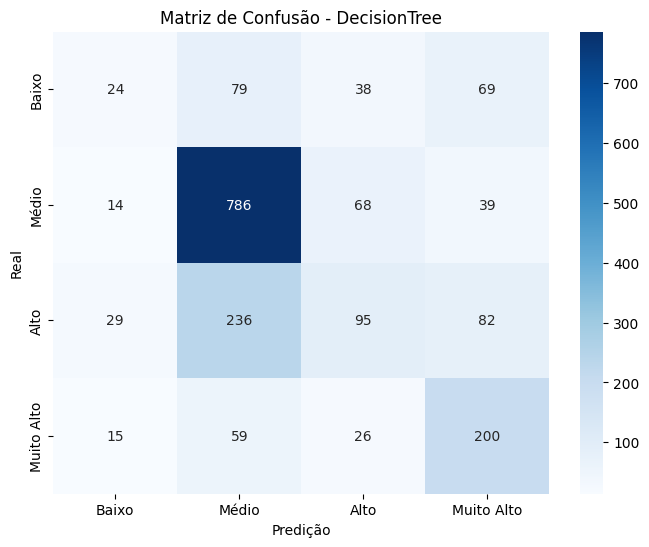


Relatório de Classificação para DecisionTree:
              precision    recall  f1-score   support

       Baixo       0.29      0.11      0.16       210
       Médio       0.68      0.87      0.76       907
        Alto       0.42      0.21      0.28       442
  Muito Alto       0.51      0.67      0.58       300

    accuracy                           0.59      1859
   macro avg       0.48      0.47      0.45      1859
weighted avg       0.55      0.59      0.55      1859

Tempo de treinamento: 0.3602 segundos

==================== NeuralNetwork ====================


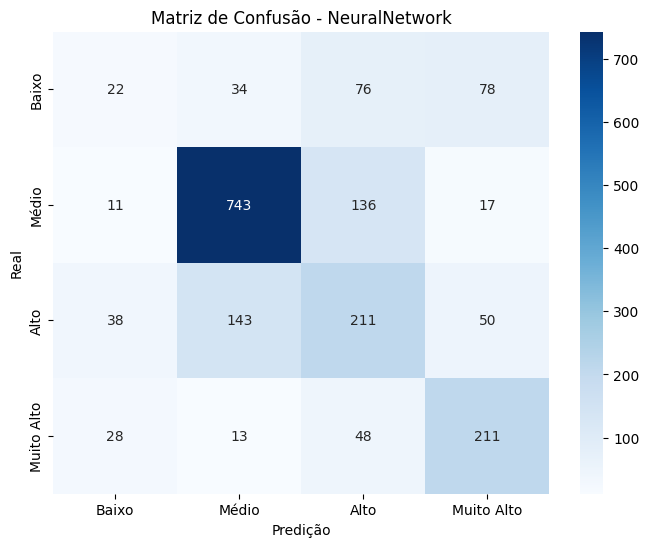


Relatório de Classificação para NeuralNetwork:
              precision    recall  f1-score   support

       Baixo       0.22      0.10      0.14       210
       Médio       0.80      0.82      0.81       907
        Alto       0.45      0.48      0.46       442
  Muito Alto       0.59      0.70      0.64       300

    accuracy                           0.64      1859
   macro avg       0.51      0.53      0.51      1859
weighted avg       0.62      0.64      0.62      1859

Tempo de treinamento: 31.3507 segundos

==================== NaiveBayes ====================


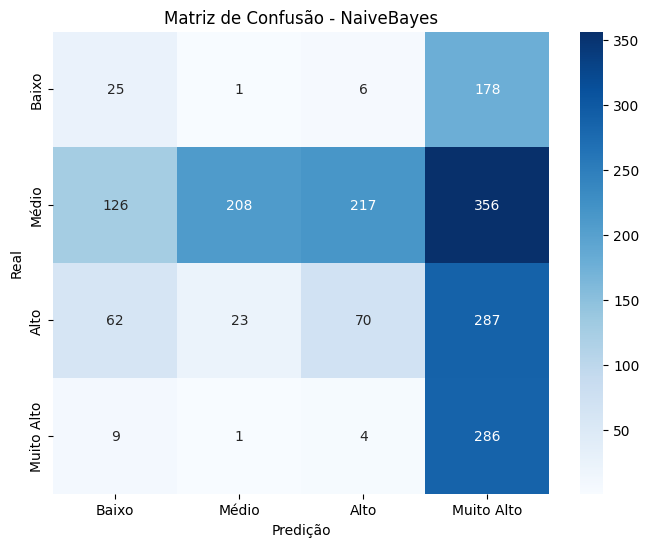


Relatório de Classificação para NaiveBayes:
              precision    recall  f1-score   support

       Baixo       0.11      0.12      0.12       210
       Médio       0.89      0.23      0.36       907
        Alto       0.24      0.16      0.19       442
  Muito Alto       0.26      0.95      0.41       300

    accuracy                           0.32      1859
   macro avg       0.37      0.37      0.27      1859
weighted avg       0.55      0.32      0.30      1859

Tempo de treinamento: 0.0981 segundos


In [89]:
import warnings
warnings.filterwarnings('ignore') 

param_grids = {
    "LogisticRegression": {
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [500, 1000]
    },
    "RandomForest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    "DecisionTree": {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "NeuralNetwork": {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001]
    }
}

# Modificando o loop de treinamento para usar GridSearchCV
nome_melhor_modelo_tomek = ""
melhor_score = 0.0
resultados_tomek = []

for name, model in models_best_parameters.items():
    print(f"\n==================== {name} ====================")
    
    # Ignorar NaiveBayes pois não tem hiperparâmetros para otimizar
    # if name == "NaiveBayes":
    #     grid_search = model
    # else:
    #     # Configurar e executar GridSearchCV
    #     grid_search = GridSearchCV(
    #         estimator=model,
    #         param_grid=param_grids[name],
    #         cv=5,
    #         n_jobs=-1,
    #         scoring='accuracy',
    #         verbose=1
    #     )
    
    # Treinamento com medição de tempo
    inicio = time.time()
    model.fit(X_train, y_train)
    fim = time.time()
    tempo_treino = fim - inicio

    # Previsões usando os melhores parâmetros
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)

    # Atualizar melhor modelo se necessário
    if acc_test > melhor_score:
        print(f"✨ Novo melhor modelo encontrado: {name} com acurácia de {acc_test:.4f}!")
        melhor_score = acc_test
        nome_melhor_modelo_tomek = name

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusão - {name}')
    plt.show()

    # Imprimir resultados detalhados
    print(f"\nRelatório de Classificação para {name}:")
    print(classification_report(y_test, y_pred_test, target_names=labels))
    print(f"Tempo de treinamento: {tempo_treino:.4f} segundos")
    
    # if name != "NaiveBayes":
    #     print("\nMelhores parâmetros encontrados:")
    #     print(f"Melhor score CV: {model.best_score_:.4f}")
    
    print("=" * 52)

    # Armazenar resultados
    resultados_tomek.append({
        "Modelo": name,
        "Acurácia Teste": acc_test,
        "Tempo Treino (s)": round(tempo_treino, 4),
    })

### Exibindo Resuldados

In [90]:
df_resultados_tomek = pd.DataFrame(resultados_tomek)
df_resultados_tomek

,Modelo,Acurácia Teste,Tempo Treino (s)
0,LogisticRegression,0.642819,27.8705
1,RandomForest,0.629909,5.1016
2,SVM,0.633136,30.3346
3,KNN,0.593330,0.0087
4,DecisionTree,0.594406,0.3602
5,NeuralNetwork,0.638515,31.3507
6,NaiveBayes,0.316837,0.0981


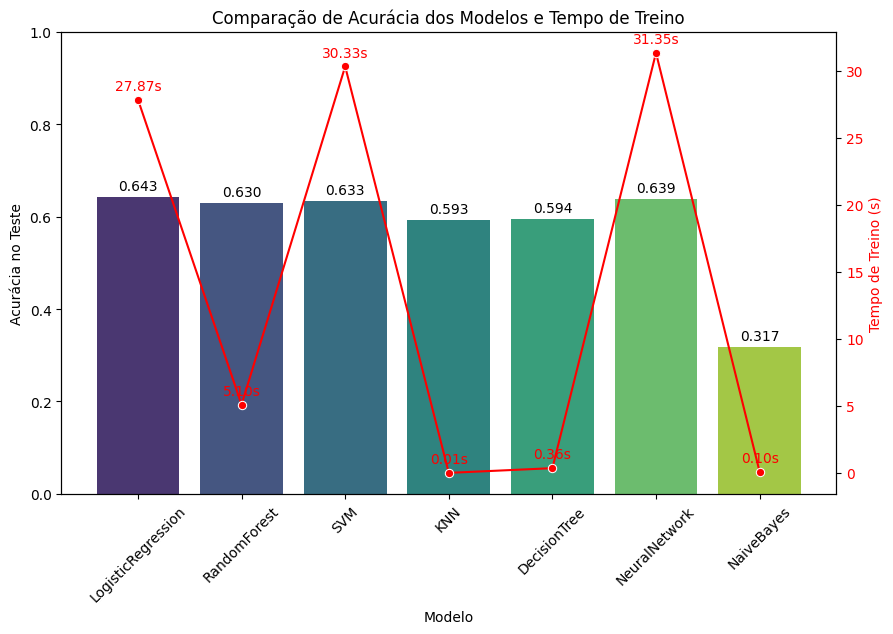

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

# Barplot da acurácia
sns.barplot(data=df_resultados_tomek, x='Modelo', y='Acurácia Teste', palette='viridis', ax=ax1, hue='Modelo', legend=False)
ax1.set_ylabel('Acurácia no Teste')
ax1.set_xlabel('Modelo')
ax1.set_ylim(0, 1)
ax1.set_title('Comparação de Acurácia dos Modelos e Tempo de Treino')
ax1.tick_params(axis='x', rotation=45)

# Adiciona os valores em cima das barras de acurácia
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.3f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                 textcoords='offset points')

# Cria um segundo eixo y para o tempo de treino
ax2 = ax1.twinx()
line = sns.lineplot(data=df_resultados_tomek, x='Modelo', y='Tempo Treino (s)', marker='o', color='red', ax=ax2)
ax2.set_ylabel('Tempo de Treino (s)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adiciona os valores do tempo de treino acima dos pontos
for x, y in zip(df_resultados_tomek['Modelo'], df_resultados_tomek['Tempo Treino (s)']):
    ax2.annotate(f'{y:.2f}s', (x, y), color='red', fontsize=10, ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.show()

### Salvando modelo

In [ ]:
if nome_melhor_modelo is not None:
    # Cria diretório para modelos se não existir
    import os
    model_dir = "modelos"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    # Salvando o melhor modelo
    joblib.dump(melhor_pipeline, f"{model_dir}/{nome_melhor_modelo}_tomek.pkl")
    
    # Salvando os transformers
    joblib.dump(scaler_std, f"{model_dir}/scaler.pkl")
    joblib.dump(ohe_enc, f"{model_dir}/encoder.pkl")
    
    print(f"\n✅ Modelo e transformers salvos com sucesso:")
    print(f"   - Modelo: '{nome_melhor_modelo}_tomek.pkl'")
    print(f"   - Scaler: 'scaler.pkl'")
    print(f"   - Encoder: 'encoder.pkl'")
    print(f"   Acurácia no teste: {melhor_score:.4f}")
    
    # Salvando informações sobre features para referência futura
    feature_info = {
        'numeric_features': num_features,
        'categorical_features': cat_features,
        'target_labels': labels  # Usando os labels definidos anteriormente
    }
    
    import json
    with open(f"{model_dir}/feature_info.json", 'w') as f:
        json.dump(feature_info, f, indent=4)
    
    print("\nℹ️ Informações sobre features salvas em 'feature_info.json'")
else:
    print("\n❌ Nenhum modelo foi treinado ou salvo.")


✅ Modelo e transformers salvos com sucesso:
   - Modelo: 'LogisticRegression_tomek.pkl'
   - Scaler: 'scaler.pkl'
   - Encoder: 'encoder.pkl'
   Acurácia no teste: 0.6428

ℹ️ Informações sobre features salvas em 'feature_info.json'


# Treinando modelos com PCA


In [93]:
melhor_pipeline_pca = None
nome_melhor_modelo_pca = ""
melhor_score_pca = 0.0 


==================== LogisticRegression (com PCA) ====================


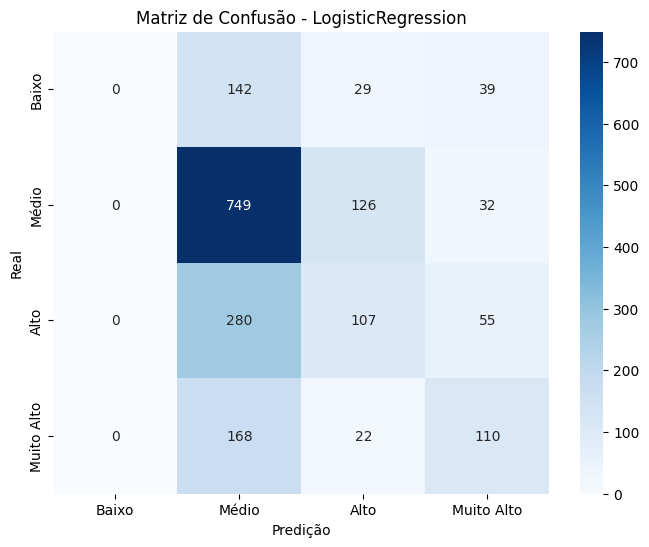


Relatório de Classificação para LogisticRegression:
              precision    recall  f1-score   support

       Baixo       0.00      0.00      0.00       210
       Médio       0.56      0.83      0.67       907
        Alto       0.38      0.24      0.29       442
  Muito Alto       0.47      0.37      0.41       300

    accuracy                           0.52      1859
   macro avg       0.35      0.36      0.34      1859
weighted avg       0.44      0.52      0.46      1859

Tempo de treinamento: 0.1130 segundos

==================== RandomForest (com PCA) ====================


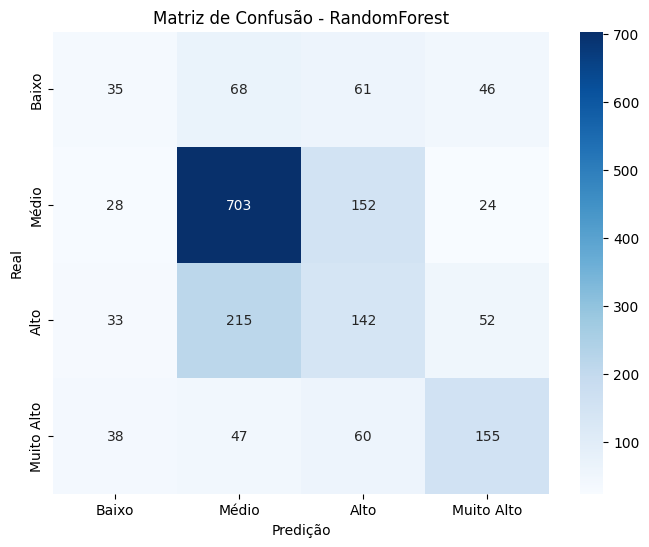


Relatório de Classificação para RandomForest:
              precision    recall  f1-score   support

       Baixo       0.26      0.17      0.20       210
       Médio       0.68      0.78      0.72       907
        Alto       0.34      0.32      0.33       442
  Muito Alto       0.56      0.52      0.54       300

    accuracy                           0.56      1859
   macro avg       0.46      0.44      0.45      1859
weighted avg       0.53      0.56      0.54      1859

Tempo de treinamento: 1.0810 segundos

==================== SVM (com PCA) ====================


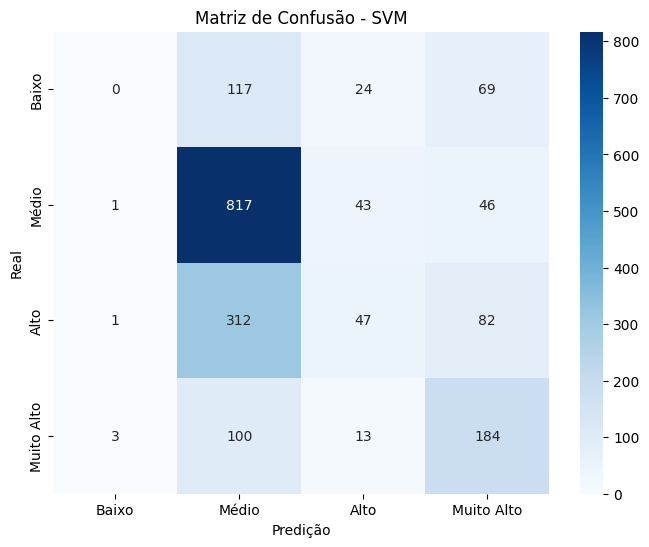


Relatório de Classificação para SVM:
              precision    recall  f1-score   support

       Baixo       0.00      0.00      0.00       210
       Médio       0.61      0.90      0.73       907
        Alto       0.37      0.11      0.17       442
  Muito Alto       0.48      0.61      0.54       300

    accuracy                           0.56      1859
   macro avg       0.37      0.41      0.36      1859
weighted avg       0.46      0.56      0.48      1859

Tempo de treinamento: 2.7127 segundos

==================== KNN (com PCA) ====================


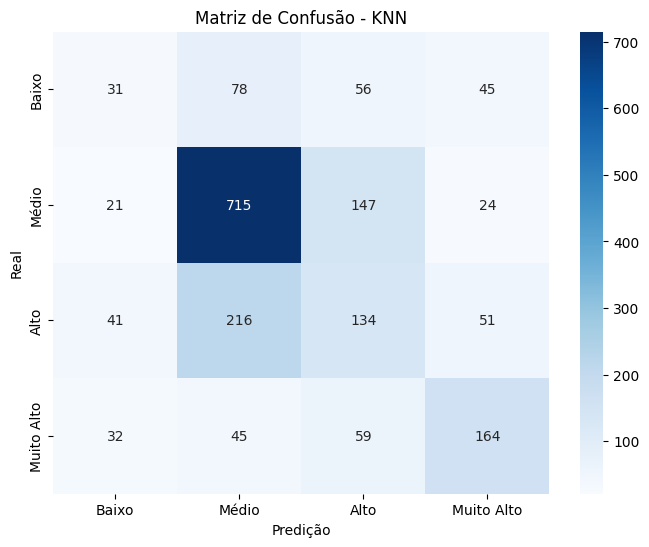


Relatório de Classificação para KNN:
              precision    recall  f1-score   support

       Baixo       0.25      0.15      0.19       210
       Médio       0.68      0.79      0.73       907
        Alto       0.34      0.30      0.32       442
  Muito Alto       0.58      0.55      0.56       300

    accuracy                           0.56      1859
   macro avg       0.46      0.45      0.45      1859
weighted avg       0.53      0.56      0.54      1859

Tempo de treinamento: 0.0123 segundos

==================== DecisionTree (com PCA) ====================


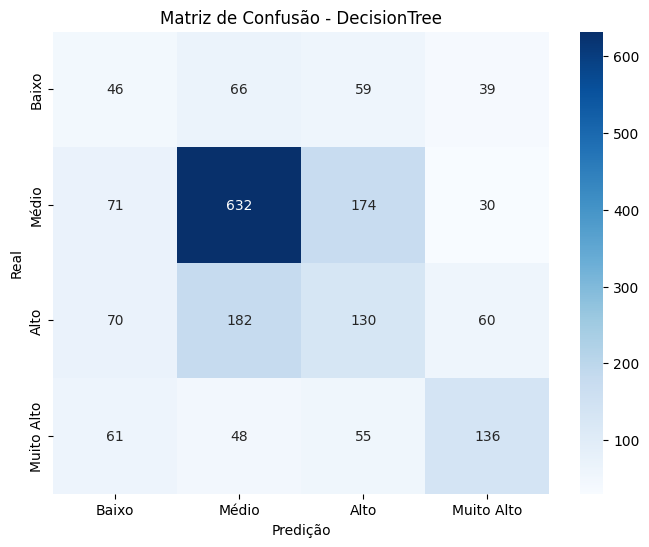


Relatório de Classificação para DecisionTree:
              precision    recall  f1-score   support

       Baixo       0.19      0.22      0.20       210
       Médio       0.68      0.70      0.69       907
        Alto       0.31      0.29      0.30       442
  Muito Alto       0.51      0.45      0.48       300

    accuracy                           0.51      1859
   macro avg       0.42      0.42      0.42      1859
weighted avg       0.51      0.51      0.51      1859

Tempo de treinamento: 0.0485 segundos

==================== NeuralNetwork (com PCA) ====================


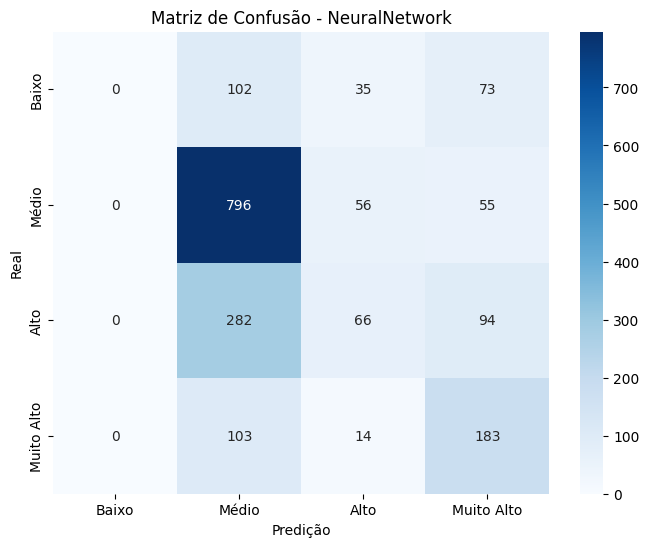


Relatório de Classificação para NeuralNetwork:
              precision    recall  f1-score   support

       Baixo       0.00      0.00      0.00       210
       Médio       0.62      0.88      0.73       907
        Alto       0.39      0.15      0.22       442
  Muito Alto       0.45      0.61      0.52       300

    accuracy                           0.56      1859
   macro avg       0.36      0.41      0.37      1859
weighted avg       0.47      0.56      0.49      1859

Tempo de treinamento: 1.4542 segundos

==================== NaiveBayes (com PCA) ====================


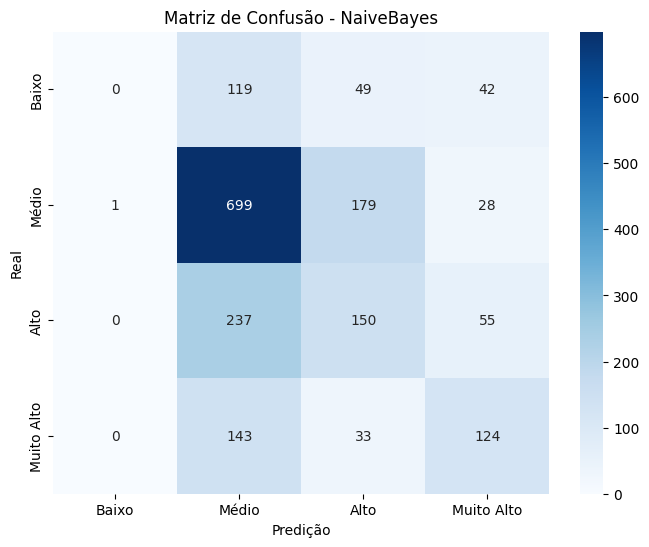


Relatório de Classificação para NaiveBayes:
              precision    recall  f1-score   support

       Baixo       0.00      0.00      0.00       210
       Médio       0.58      0.77      0.66       907
        Alto       0.36      0.34      0.35       442
  Muito Alto       0.50      0.41      0.45       300

    accuracy                           0.52      1859
   macro avg       0.36      0.38      0.37      1859
weighted avg       0.45      0.52      0.48      1859

Tempo de treinamento: 0.0086 segundos


In [95]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

for name, model in models_best_parameters.items():
    print(f"\n==================== {name} (com PCA) ====================")

    inicio = time.time()
    model.fit(X_train_pca, y_train)
    fim = time.time()
    tempo_treino = fim - inicio

    y_pred_test = model.predict(X_test_pca)

    acc_test = accuracy_score(y_test, y_pred_test)

    if acc_test > melhor_score:
        print(f"✨ Novo melhor modelo encontrado: {name} com acurácia de {acc_test:.4f}!")
        melhor_score_pca = acc_test
        melhor_pipeline_pca = model  
        nome_melhor_modelo_pca = name

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusão - {name}')
    plt.show()

    print(f"\nRelatório de Classificação para {name}:")
    print(classification_report(y_test, y_pred_test, target_names=labels))
    print(f"Tempo de treinamento: {tempo_treino:.4f} segundos")
    print("=" * 52)

    resultados.append({
        "Modelo": name,
        "Acurácia Teste": acc_test,
        "Tempo Treino (s)": round(tempo_treino, 4)
    })


In [ ]:
df_resultados = pd.DataFrame(resultados)
df_resultados

In [ ]:
if melhor_pipeline_pca is not None:
    joblib.dump(melhor_pipeline_pca, f"{nome_melhor_modelo_pca}_pca.pkl")
    print(f"\n✅ Melhor modelo ('{nome_melhor_modelo_pca}') foi salvo no arquivo '{nome_melhor_modelo_pca}_pca.pkl'")
    print(f"   Acurácia no teste: {melhor_score_pca:.4f}")
else:
    print("\n❌ Nenhum modelo foi treinado ou salvo.")

### Cross Validator


In [ ]:
# Cross-validation para todos os modelos
from sklearn.model_selection import cross_val_score, KFold

# Definindo o k-fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Dicionário para armazenar os resultados do CV
cv_results = {}

print("\n=== Resultados do Cross-Validation (5-fold) ===\n")

# Executando CV para cada modelo
for name, model in models_best_parameters.items():
    # Realizando cross-validation
    cv_scores = cross_val_score(model, X_final, y, cv=kfold, scoring='accuracy')
    
    # Armazenando resultados
    cv_results[name] = {
        'mean_score': cv_scores.mean(),
        'std_score': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"\n{name}:")
    print(f"Acurácia média: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Scores individuais: {cv_scores}")

# Criando DataFrame com resultados
cv_df = pd.DataFrame({
    'Modelo': list(cv_results.keys()),
    'Acurácia Média': [cv_results[model]['mean_score'] for model in cv_results],
    'Desvio Padrão': [cv_results[model]['std_score'] for model in cv_results]
})

print("\n=== Resumo dos Resultados ===")
print(cv_df.sort_values(by='Acurácia Média', ascending=False))

# Visualização dos resultados
plt.figure(figsize=(12, 6))
plt.boxplot([cv_results[model]['scores'] for model in cv_results], labels=list(cv_results.keys()))
plt.title('Comparação de Performance dos Modelos (Cross-Validation)')
plt.ylabel('Acurácia')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()